
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 6 - Actor Critic part 1 </b></center></h2>

<br>
<center><font size="3">This notebook is part of the teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2023 - Nov 30, 2023</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Learning Objectives </a>
* <a href='#1.2'> 1.2 Code Structure & Files </a>
* <a href='#2.'> 2. Policy Gradient with a Critic </a>
* <a href='#3.'> 3. Submitting </a>
* <a href='#3.1'> 3.1 Feedback </a>
* <a href='#4.'> References</a>

<a href='#T1'><b>Student Task 1.</b> Implementing PG with critic (20 points)</a>\
<a href='#Q1'><b>Student Question 1.1</b> Relationship between actor-critic and REINFORCE with baseline (10 points)</a>\
<a href='#Q2'><b>Student Question 1.2</b> Advantage (5 points)  </a>\
<a href='#Q3'><b>Student Question 1.3</b> Bias and Variance Analysis (10 points) </a>\
<a href='#Q4'><b>Student Question 1.4</b> Controlling bias-variance tradeoff (10 points)</a>
    
**Total Points:** 55

# 1. Introduction <a id='1.'></a>

In this assignment, we will implement an actor-critic reinforcement learning algorithm which combines elements of both value-based methods (critic) and policy-based methods (actor) to improve learning and stability in the **InvertedPendulum-v4**  environment.

## 1.1 Task environments: <a id='1.1'></a>

In this exercise, we will focus on InvertedPendulum-v4 tasks:
- InvertedPendulum-v4(https://www.gymlibrary.dev/environments/mujoco/inverted_pendulum/): This environment is similar to the cartpole environment but now powered by the Mujoco physics simulator - allowing for more complex experiments (such as varying the effects of gravity). This environment involves a cart that moves horizontally, with a pole fixed on the cart at one end and the other end of the pole moving freely. The cart can be pushed left or right. The goal is to move the pole such that it is vertically above the cart pointing straight up by applying horizontal forces on the cart.
<figure style="text-align: center">
    <img src="imgs/InvertedPendulum.png" width="300"/>
    <figcaption style="text-align: center">  Figure 1: The InvertedPendulum-v4 environment. </figcaption>
</figure>

## 1.2 Learning Objectives: <a id='1.1'></a>

- Understand the idea of actor-critic algorithms
- Understand the limits and use cases of actor-critics

## 1.3 Code Structure & Files <a id='1.2'></a>

```ex6_PG_AC.ipynb``` is the file needed to be modified for this part of the assignment.  

<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER PART IN ```ex6_DDPG.ipynb```** </span>

```
├───cfg                            # Config files for environments
├───imgs                           # Images used in notebook
├───results
│   └───HalfCheetah-v4
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*HalfCheetah-v4_params.pt    # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*ddpg.png               # Contains training performance plot
│   └───InvertedPendulum-v4
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*InvertedPendulum-v4_params.pt      # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*pg_ac.png              # Contains training performance plot
│   ex6_DDPG.ipynb                  # 2nd assignment file containing tasks <---------
│   ex6_PG_AC.ipynb                 # 1st assignment file containing tasks <---------This task
│   train.py                        # Contains train and test functions 
│   utils.py                        # Contains useful functions 
└───buffer.py                       # Contains buffer functions
```

## 1.4 Execution time <a id='1.4'></a>

The training of DDPG may take more than 15 mins depending on the server load. If you have problems with the training time, you can train locally.


# 2. Policy Gradient with a Critic <a id='2.'></a>

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Implement policy gradient (PG) with critic (20 points) </h3> 

Revisit the policy gradient solution for the InvertedPendulum from Exercise 5 with learned sigma if needed. Implement the actor-critic algorithm below. Perform TD(0) updates at the end of each episode. You can check the training performance plot in the result folder after running the plot cell. Take Figure 2 as a reference training plot. 
    
**Hint:** Check out the PyTorch tutorial from Mycourses to see how to calculate the $A_\theta \Delta_\theta \log \pi_\theta(a_i|s_i)$ term using the ```detach()``` function. 

<figure style="text-align: center">
<img src="imgs/pg_ac.png" width="400px">
<figcaption style="text-align: center"> Figure 2: Training plot of the policy gradient with a critic.
</figcaption>
</figure>
     
**Complete the all the unfinished implementation in `PG` class (marked with ```TODOs```)**. 
    
1. **Policy Network**: Finish the `__init__(self, state_dim, action_dim)` function and `forward(self, state)` function within the `Policy` class
2. **Agent Update Function**: Finish the `update(self, )` function within the `PG` class
3. **Get Action Method**: Finish the `get_action(self, observation, evaluation=False)` function within the `PG` class.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [2]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))
import torch, yaml
import torch.nn.functional as F
from torch import nn
from torch.distributions import Normal
import numpy as np
from pathlib import Path
from IPython.display import Video


import train as t
import utils as u

device = 'cpu'

In [15]:
# Actor-critic agent
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # Create a neural network and use it for the mean of the policy.
        # The size of the neural network here has been chosen such that 
        # it is not too big but should perform well in the tasks we want to look at.
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(state_dim, 64)), nn.Tanh(),
            layer_init(nn.Linear(64, 64)), nn.Tanh(),
            layer_init(nn.Linear(64, action_dim), std=0.01),
        )
        # TODO: Implement actor_logstd as a learnable parameter
        # Use log of std to make sure std (standard deviation) of the policy
        # doesn't become negative during training
        self.actor_logstd = torch.nn.Parameter(torch.Tensor([0.0])).to(device)


    def forward(self, state):
        # Get mean of a Normal distribution (the output of the neural network)
        action_mean = self.actor_mean(state)

        # Make sure action_logstd matches dimensions of action_mean
        action_logstd = self.actor_logstd.expand_as(action_mean)

        # Exponentiate the log std to get actual std
        action_std = torch.exp(action_logstd)

        # TODO: Create a Normal distribution with mean of 'action_mean' and standard deviation of 'action_logstd', and return the distribution
        probs = Normal(action_mean, action_std)

        return probs

class Value(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.value = nn.Sequential(
            layer_init(nn.Linear(state_dim, 64)), nn.Tanh(),
            layer_init(nn.Linear(64, 64)), nn.Tanh(),
            layer_init(nn.Linear(64, 1)))
    
    def forward(self, x):
        return self.value(x).squeeze(1) # output shape [batch,]


class PG(object):
    def __init__(self, state_dim, action_dim, lr, gamma):
        self.name = 'pg'
        self.policy = Policy(state_dim, action_dim).to(device)
        self.value = Value(state_dim).to(device)
        self.optimizer = torch.optim.Adam(list(self.policy.parameters())+ list(self.value.parameters()), 
                                         lr=float(lr),)

        self.gamma = gamma

        # a simple buffer
        self.states = []
        self.action_probs = []
        self.rewards = []
        self.dones = []
        self.next_states = []


    def update(self,):
        action_probs = torch.stack(self.action_probs, dim=0) \
                .to(device).squeeze(-1)
        rewards = torch.stack(self.rewards, dim=0).to(device).squeeze(-1)
        states = torch.stack(self.states, dim=0).to(device).squeeze(-1)
        next_states = torch.stack(self.next_states, dim=0).to(device).squeeze(-1)
        dones = torch.stack(self.dones, dim=0).to(device).squeeze(-1)
        # clear buffer
        self.states, self.action_probs, self.rewards, self.dones, self.next_states = [], [], [], [], []

        # TODO:
        ########## Your code starts here. ##########
        # Hints: 1. calculate the TD target as well as the MSE loss between the predicted value and the TD target
        #        2. calculate the policy loss (similar to ex5) with advantage calculated from the value function. Normalise
        #           the advantage to zero mean and unit variance.
        #        3. update parameters of the policy and the value function jointly


        # calculate the target values
        states_values = self.value.forward(states)
        next_states_values = self.value.forward(next_states)
        td_target = rewards + self.gamma * self.value.forward(next_states)*(1-dones)
        
        # calculate the critic_loss
        critic_loss = torch.mean(torch.square(states_values - td_target.detach()))
        
        # Advantage estimation
        adv = td_target - states_values
        (std, mean) = torch.std_mean(adv)
        norm_adv = (adv - mean)/std
        
        # Compute the optimization term 
        actor_loss = - torch.mean(action_probs.squeeze(-1) * norm_adv.detach())
        comb_loss = actor_loss + critic_loss
        
        # Compute the gradients of loss w.r.t. network parameters 
        comb_loss.backward()

        # Update network parameters using self.optimizer and zero gradients 
        self.optimizer.step()
        self.optimizer.zero_grad()

        ########## Your code ends here. ##########

        return {}


    def get_action(self, observation, evaluation=False):
        """Return action (np.ndarray) and logprob (torch.Tensor) of this action."""
        if observation.ndim == 1: observation = observation[None] # add the batch dimension
        x = torch.from_numpy(observation).float().to(device)

        # TODO: Task 1
        ########## Your code starts here. ##########
        # Hints: 1. the self.policy returns a normal distribution, check the PyTorch document to see 
        #           how to calculate the log_prob of an action and how to sample.
        #        2. if evaluating the policy, return policy mean, otherwise, return a sample
        #        3. the returned action and the act_logprob should be torch.Tensors.
        #            Please always make sure the shape of variables is as you expected.
        
        # calculate action
        normal_dist = self.policy.forward(x)
        if evaluation:
            action = normal_dist.mean
        else:
            action = normal_dist.sample((1,))[0]
        act_logprob = normal_dist.log_prob(action)
        ########## Your code ends here. ###########

        return action, act_logprob


    def record(self, observation, action_prob, next_observation, reward, done):
        self.states.append(torch.tensor(observation, dtype=torch.float32))
        self.action_probs.append(action_prob)
        self.rewards.append(torch.tensor([reward], dtype=torch.float32))
        self.dones.append(torch.tensor([done], dtype=torch.float32))
        self.next_states.append(torch.tensor(next_observation, dtype=torch.float32))


    def load(self, filepath):
        d = torch.load(filepath)
        self.policy.load_state_dict(d['policy'])
        self.value.load_state_dict(d['value'])
    
    def save(self, filepath):
        torch.save({
            'policy': self.policy.state_dict(),
            'value': self.value.state_dict(),
        }, filepath)

In [16]:
# init agent
with open(Path().cwd()/'cfg'/'pg_ac.yaml', 'r') as f:
    cfg = u.Struct(**yaml.safe_load(f))
    
agent = PG(cfg.state_shape[0], cfg.action_dim, cfg.lr, cfg.gamma)

In [17]:
t.train(agent, cfg_path=Path().cwd()/'cfg'/'pg_ac.yaml', cfg_args={})

Numpy/Torch/Random Seed:  90
{'episode': 0, 'timesteps': 5, 'ep_reward': 5.0}
{'episode': 50, 'timesteps': 6, 'ep_reward': 6.0}
{'episode': 100, 'timesteps': 16, 'ep_reward': 16.0}
{'episode': 150, 'timesteps': 7, 'ep_reward': 7.0}
{'episode': 200, 'timesteps': 8, 'ep_reward': 8.0}
{'episode': 250, 'timesteps': 16, 'ep_reward': 16.0}
{'episode': 300, 'timesteps': 86, 'ep_reward': 86.0}
{'episode': 350, 'timesteps': 83, 'ep_reward': 83.0}
{'episode': 400, 'timesteps': 185, 'ep_reward': 185.0}
{'episode': 450, 'timesteps': 93, 'ep_reward': 93.0}
{'episode': 500, 'timesteps': 129, 'ep_reward': 129.0}
{'episode': 550, 'timesteps': 54, 'ep_reward': 54.0}
{'episode': 600, 'timesteps': 123, 'ep_reward': 123.0}
{'episode': 650, 'timesteps': 80, 'ep_reward': 80.0}
{'episode': 700, 'timesteps': 59, 'ep_reward': 59.0}
{'episode': 750, 'timesteps': 149, 'ep_reward': 149.0}
{'episode': 800, 'timesteps': 99, 'ep_reward': 99.0}
{'episode': 850, 'timesteps': 219, 'ep_reward': 219.0}
{'episode': 900, '

Numpy/Torch/Random Seed:  860


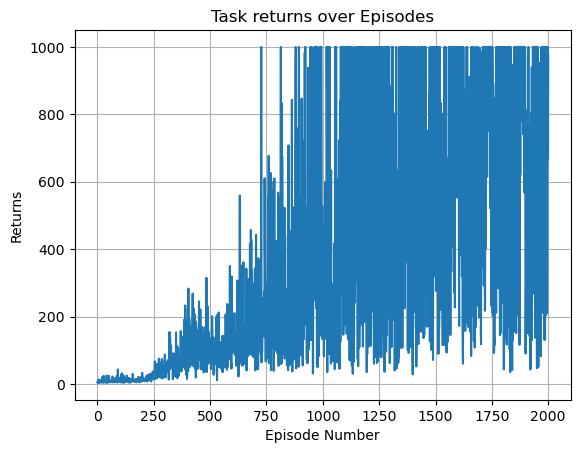

In [18]:
t.plot(cfg_path=Path().cwd()/'cfg'/'pg_ac.yaml',)

In [19]:
t.test(agent, cfg_path=Path().cwd()/'cfg'/'pg_ac.yaml', cfg_args=dict(save_video=True,testing=True))

Numpy/Torch/Random Seed:  754
Loading model from /notebooks/rl2023/ex6/results/InvertedPendulum-v4/model/InvertedPendulum-v4_params.pt ...
Testing ...
Moviepy - Building video /notebooks/rl2023/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-0.mp4.
Moviepy - Writing video /notebooks/rl2023/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/rl2023/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-0.mp4
Ep0: Test ep_reward is 1000.0
Ep1: Test ep_reward is 1000.0
Ep2: Test ep_reward is 1000.0
Ep3: Test ep_reward is 1000.0
Ep4: Test ep_reward is 1000.0
Ep5: Test ep_reward is 1000.0
Ep6: Test ep_reward is 1000.0
Ep7: Test ep_reward is 1000.0
Ep8: Test ep_reward is 1000.0
Moviepy - Building video /notebooks/rl2023/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-9.mp4.
Moviepy - Writing video /notebooks/rl2023/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/rl2023/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-9.mp4
Ep9: Test ep_reward is 1000.0
Average test reward: 1000.0


In [20]:
Video(Path().cwd()/'results'/'InvertedPendulum-v4'/'video'/'test'/'ex6-episode-9.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.1</b> Relationship between actor-critic and REINFORCE with baseline (10 points) </h3> 

What is the relationship between actor-critic and REINFORCE with baseline?
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

1. In the REINFORCE algorithm with a baseline, it is beneficial to use an estimate of the state value function, denoted as $V(s_t)$, which can be learned from the collected data.

2. Actor-critic methods take this concept further by incorporating the value function estimate as a critical component, known as the "critic" model.

3. In actor-critic methods, the critic model plays a crucial role in determining the Temporal Difference (TD) target, which guides the learning process of the actor (policy).

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.2</b> Advantage (5 points) </h3> 

How can the value of advantage be intuitively interpreted?
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

1. Advantage tells you how much your chosen action 'a' boosts your total reward compared to what you usually get in that situation.

2. To put it another way, it helps you see if your chosen action is better or worse than the other options available at that moment.

<a id='Q3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.3</b> Bias and Variance Analysis (10 points) </h3> 

How does the implemented actor-critic method compare to REINFORCE in terms of bias and variance of the policy gradient estimation? Explain your answer.    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

1. REINFORCE is a Monte Carlo (MC) approach for reinforcement learning, while the actor-critic model is a Temporal Difference (TD) approach.

2. Due to the use of bootstrapping in the actor-critic method, we can anticipate some specific characteristics:

- The actor-critic method tends to introduce more bias and less variance in its estimates compared to the REINFORCE algorithm.

- This bias and variance reduction is a result of the bootstrapping technique, where the critic model estimates values based on earlier predictions and reduces the reliance on full episode returns.

<a id='Q4'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.4</b> Controlling bias-variance tradeoff (10 points) </h3> 

How could the bias-variance tradeoff in actor-critic be controlled?
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

1. Implementing TD-$\lambda$, a variant of Temporal Difference learning, enables control over the bias-variance tradeoff in reinforcement learning.

2. Different values of $\lambda$ can be chosen to fine-tune this tradeoff, where $\lambda = 0$ corresponds to the current actor-critic approach.

3. On the other hand, setting $\lambda = 1$ makes the algorithm resemble the Monte Carlo approach, which focuses more on long-term cumulative rewards.

4. By adjusting $\lambda$, we can decide how much weight to give to immediate rewards versus long-term rewards in our learning process.

# 3. Submitting <a id='3.'></a>
Ensure all tasks and questions (in ```ex6_DDPG.ipynb``` and ```ex6_PG_AC.ipynb```) are answered and the necessary plots are saved in the appropriate locations. The relevant plots and files needed to be submitted for this assignment are:


- Training performance plots:
  - `pg_ac.png`: Training performance plots in terms of episode and episodic reward
<br>

  
- Model files:
  - `InvertedPendulum-v4_params.pt`: Trained model


Ensure the model files and plots are saved in correct paths:
- ```results/InvertedPendulum-v4/pg_ac.png``` Training result
- ```results/InvertedPendulum-v4/model/InvertedPendulum-v4_params.pt``` Training Model


<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER TASK IN ```ex6_DDPG.ipynb```** </span>

## 3.1 Feedback <a id='3.1'></a>

In order to help the staff of the course as well as the forthcoming students, it would be great if you could answer to the following questions in your submission:

1) How much time did you spend solving this exercise? (change the ```hrs``` variable below to a floating point number representing the number of hours taken e.g. 5.43)

In [ ]:
hrs = None

2) Difficulty of each task/question from 1-5 (int or float)

In [ ]:
T1 = None   # Implementing DDPG (20 points)
Q1 = None   # Question 1.1 Relationship between actor-critic and REINFORCE with baseline (10 points)
Q2 = None   # Question 1.2 Advantage (5 points)
Q3 = None   # Question 1.3 Bias and Variance Analysis (10 points)
Q4 = None   # Question 1.4 Controlling bias-variance tradeoff (10 points)

3) How well did you understand the content of the task/question from 1-5? (int or float)

In [ ]:
T1 = None   # Implementing DDPG (20 points)
Q1 = None   # Question 1.1 Relationship between actor-critic and REINFORCE with baseline (10 points)
Q2 = None   # Question 1.2 Advantage (5 points)
Q3 = None   # Question 1.3 Bias and Variance Analysis (10 points)
Q4 = None   # Question 1.4 Controlling bias-variance tradeoff (10 points)

4) General feedback. Consider questions like:

    - Did the content of the lecture relate well with the assignment?
    - To what extent did you find the material to be potentially useful for your research and studies?
    
Please share any additional feedback, suggestions, or comments you have about the lecture, assignment, or course content. Your input is valuable in helping us improve the learning experience.

DOUBLE CLICK HERE TO EDIT, CLEAR THIS TEXT AND ANSWER HERE

# References <a id='4.'></a>
Please use the following section to record references.